In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler

In [ ]:
# --- Load SDG Index data ---
data_path = r"../data/full_data_set.xlsx"
df = pd.read_excel(data_path, sheet_name="Backdated SDG Index")

# Remove aggregates (ids starting with "_")
df = df[~df["id"].astype(str).str.startswith("_")].copy()

# --- Clean numeric columns (sdgi_s + goals) ---
n_sdg_cols = [c for c in df.columns if "n_sdg" in c or c == "sdgi_s"]
df_sdg = df[["Country", "year"] + n_sdg_cols]
df_sdg = df_sdg[df_sdg["year"].isin([2000, 2020])].copy()

df_sdg

,Country,year,sdgi_s,n_sdg1_wpc,n_sdg1_lmicpov,n_sdg2_undernsh,n_sdg2_stunting,n_sdg2_wasting,n_sdg2_mdd,n_sdg2_obesity,...,n_sdg16_justice,n_sdg16_admin,n_sdg16_exprop,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_sprofits,n_sdg17_statperf,n_sdg17_multilat
0,Afghanistan,2000,34.876604,39.740,0.000,0.000,0.00,44.172,6.857,95.511,...,27.846,12.143,8.8,34.567,NaN,0.000,100.0,100.0,19.195,28.972
20,Afghanistan,2020,47.511136,72.474,21.202,36.683,4.50,68.712,6.857,55.449,...,53.846,40.571,0.0,36.887,NaN,10.130,100.0,100.0,40.747,28.972
25,Angola,2000,46.855637,64.661,10.750,0.000,27.00,49.080,27.286,92.260,...,66.308,33.286,0.0,24.787,NaN,100.000,100.0,100.0,29.860,62.508
45,Angola,2020,51.308267,55.028,5.111,54.774,6.00,69.939,27.286,75.356,...,61.538,25.571,3.4,29.113,NaN,39.307,100.0,100.0,45.560,62.508
50,Albania,2000,66.484883,97.099,77.423,93.970,33.25,55.215,60.714,69.164,...,78.462,41.429,28.0,41.333,NaN,46.603,100.0,100.0,53.207,63.585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,South Africa,2020,63.504183,68.435,30.060,88.945,46.75,77.914,42.714,14.799,...,65.077,49.429,42.6,80.073,NaN,59.380,85.0,100.0,68.224,71.652
4775,Zambia,2000,46.637741,19.156,0.000,0.000,0.00,61.963,18.857,97.307,...,40.000,0.000,4.0,21.720,NaN,24.853,100.0,100.0,37.664,78.030
4795,Zambia,2020,53.331861,19.134,0.000,23.618,13.50,74.233,18.857,77.585,...,47.846,42.571,0.0,50.267,NaN,31.937,100.0,100.0,49.104,78.030
4800,Zimbabwe,2000,57.231471,94.309,54.938,23.869,11.75,55.828,9.571,87.461,...,46.154,27.143,0.0,28.627,NaN,0.000,100.0,100.0,21.300,58.995


In [47]:
df_2000 = df_sdg[df_sdg["year"] == 2000].set_index("Country")
df_2024 = df_sdg[df_sdg["year"] == 2020].set_index("Country")

# Align and compute growth (difference or %)
df_growth = (df_2024[n_sdg_cols] - df_2000[n_sdg_cols])  # absolute change
# If you want percentage growth instead, use:
# df_growth = (df_2024[n_sdg_cols] - df_2000[n_sdg_cols]) / df_2000[n_sdg_cols] * 100

# Reset index for a clean dataframe
df_growth = df_growth.reset_index()

df_growth

,Country,sdgi_s,n_sdg1_wpc,n_sdg1_lmicpov,n_sdg2_undernsh,n_sdg2_stunting,n_sdg2_wasting,n_sdg2_mdd,n_sdg2_obesity,n_sdg2_trophic,...,n_sdg16_justice,n_sdg16_admin,n_sdg16_exprop,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_sprofits,n_sdg17_statperf,n_sdg17_multilat
0,Afghanistan,12.634532,32.734,21.202,36.683,4.50,24.540,0.0,-40.062,21.951,...,26.000,28.428,-8.8,2.320,NaN,10.130,0.0,0.00,21.552,0.0
1,Angola,4.452629,-9.633,-5.639,54.774,-21.00,20.859,0.0,-16.904,11.708,...,-4.770,-7.715,3.4,4.326,NaN,-60.693,0.0,0.00,15.700,0.0
2,Albania,7.710145,1.887,20.024,1.256,38.50,34.969,0.0,-28.731,11.219,...,-8.154,11.714,-28.0,0.880,NaN,-0.933,0.0,0.00,21.884,0.0
3,Andorra,10.793738,NaN,NaN,0.000,0.00,0.000,NaN,-12.415,NaN,...,NaN,NaN,NaN,22.480,NaN,NaN,0.0,0.47,0.000,0.0
4,United Arab Emirates,10.049025,-0.419,-1.038,0.502,0.00,0.000,0.0,-20.340,-20.000,...,14.924,12.000,16.0,9.494,-45.555,NaN,0.0,0.00,23.281,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Samoa,2.331132,5.971,24.050,-3.266,-6.00,4.908,0.0,0.000,-23.903,...,NaN,NaN,NaN,13.200,NaN,18.830,0.0,0.00,9.009,0.0
189,"Yemen, Rep.",0.206461,-75.301,-36.926,-30.905,0.00,-6.135,0.0,-22.631,-5.366,...,NaN,NaN,NaN,-41.180,NaN,NaN,0.0,0.00,-8.016,0.0
190,South Africa,7.232601,12.825,18.151,-8.040,9.25,11.043,0.0,-23.251,-19.024,...,5.077,9.429,-9.4,29.480,NaN,15.813,0.0,0.00,0.021,0.0
191,Zambia,6.694120,-0.022,0.000,23.618,13.50,12.270,0.0,-19.722,10.000,...,7.846,42.571,-4.0,28.547,NaN,7.084,0.0,0.00,11.440,0.0


In [72]:
# clean df_growth 

# Separate country column
countries = df_growth["Country"]
temp = df_growth.drop(columns=["Country"]).copy()
temp = temp.dropna(axis=1, how='any')
temp = temp.loc[:, (temp != 0).any(axis=0)]

# Add back Country column matching remaining rows
df_growth_clean = pd.concat([countries.loc[X.index], X], axis=1)

print(df_growth_clean.shape)
df_growth_clean

(193, 13)


,Country,sdgi_s,n_sdg3_lifee,n_sdg5_parl,n_sdg6_water,n_sdg6_sanita,n_sdg6_wastewat,n_sdg7_elecac,n_sdg9_intuse,n_sdg9_mobuse,n_sdg9_uni,n_sdg9_articles,n_sdg17_sprofits
0,Afghanistan,12.634532,22.237,-0.615,61.203,35.081,0.000,97.470,15.183,17.849,0.000,0.583,0.00
1,Angola,4.452629,31.434,29.713,26.706,26.691,0.000,25.082,35.210,18.704,0.000,0.250,0.00
2,Albania,7.710145,10.338,49.795,14.452,10.864,0.000,0.660,71.613,69.158,0.000,16.667,0.00
3,Andorra,10.793738,-8.431,80.533,0.000,0.000,0.000,0.000,84.526,88.361,0.000,37.583,0.47
4,United Arab Emirates,10.049025,19.272,100.000,0.640,-0.072,0.000,0.000,78.093,84.944,37.174,71.667,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Samoa,2.331132,-0.221,3.689,17.224,6.262,0.000,13.201,50.609,11.979,0.000,26.084,0.00
189,"Yemen, Rep.",0.206461,12.669,0.000,32.975,9.831,0.000,27.173,11.876,3.206,0.000,2.750,0.00
190,South Africa,7.232601,23.386,33.607,15.313,18.381,-1.176,19.362,68.266,84.563,0.000,30.416,0.00
191,Zambia,6.694120,32.279,13.729,34.701,17.982,0.000,30.693,22.801,52.963,0.000,3.084,0.00


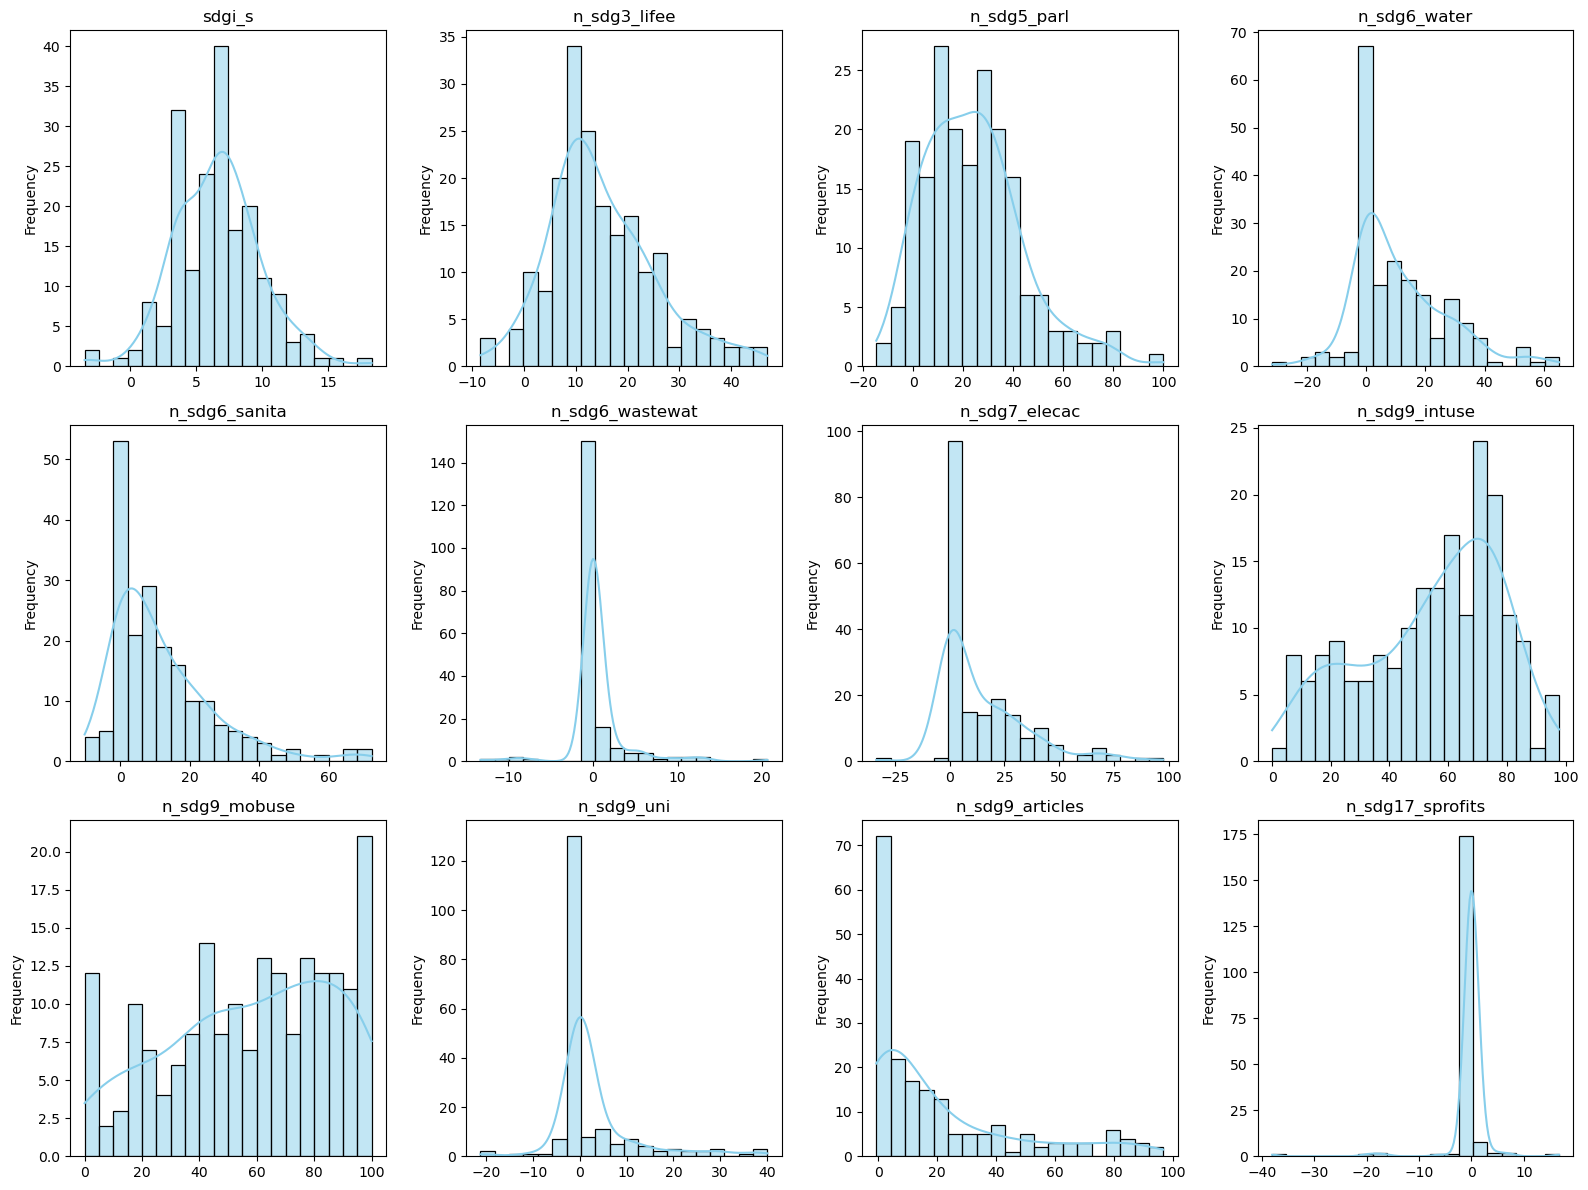

In [73]:

import matplotlib.pyplot as plt
import seaborn as sns

# Exclude Country column
df_plot = df_growth_clean.drop(columns=["Country"])

# Set up the plot grid
n_cols = 4  # number of plots per row
n_rows = (len(df_plot.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, col in enumerate(df_plot.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_plot[col], kde=True, bins=20, color="skyblue")
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


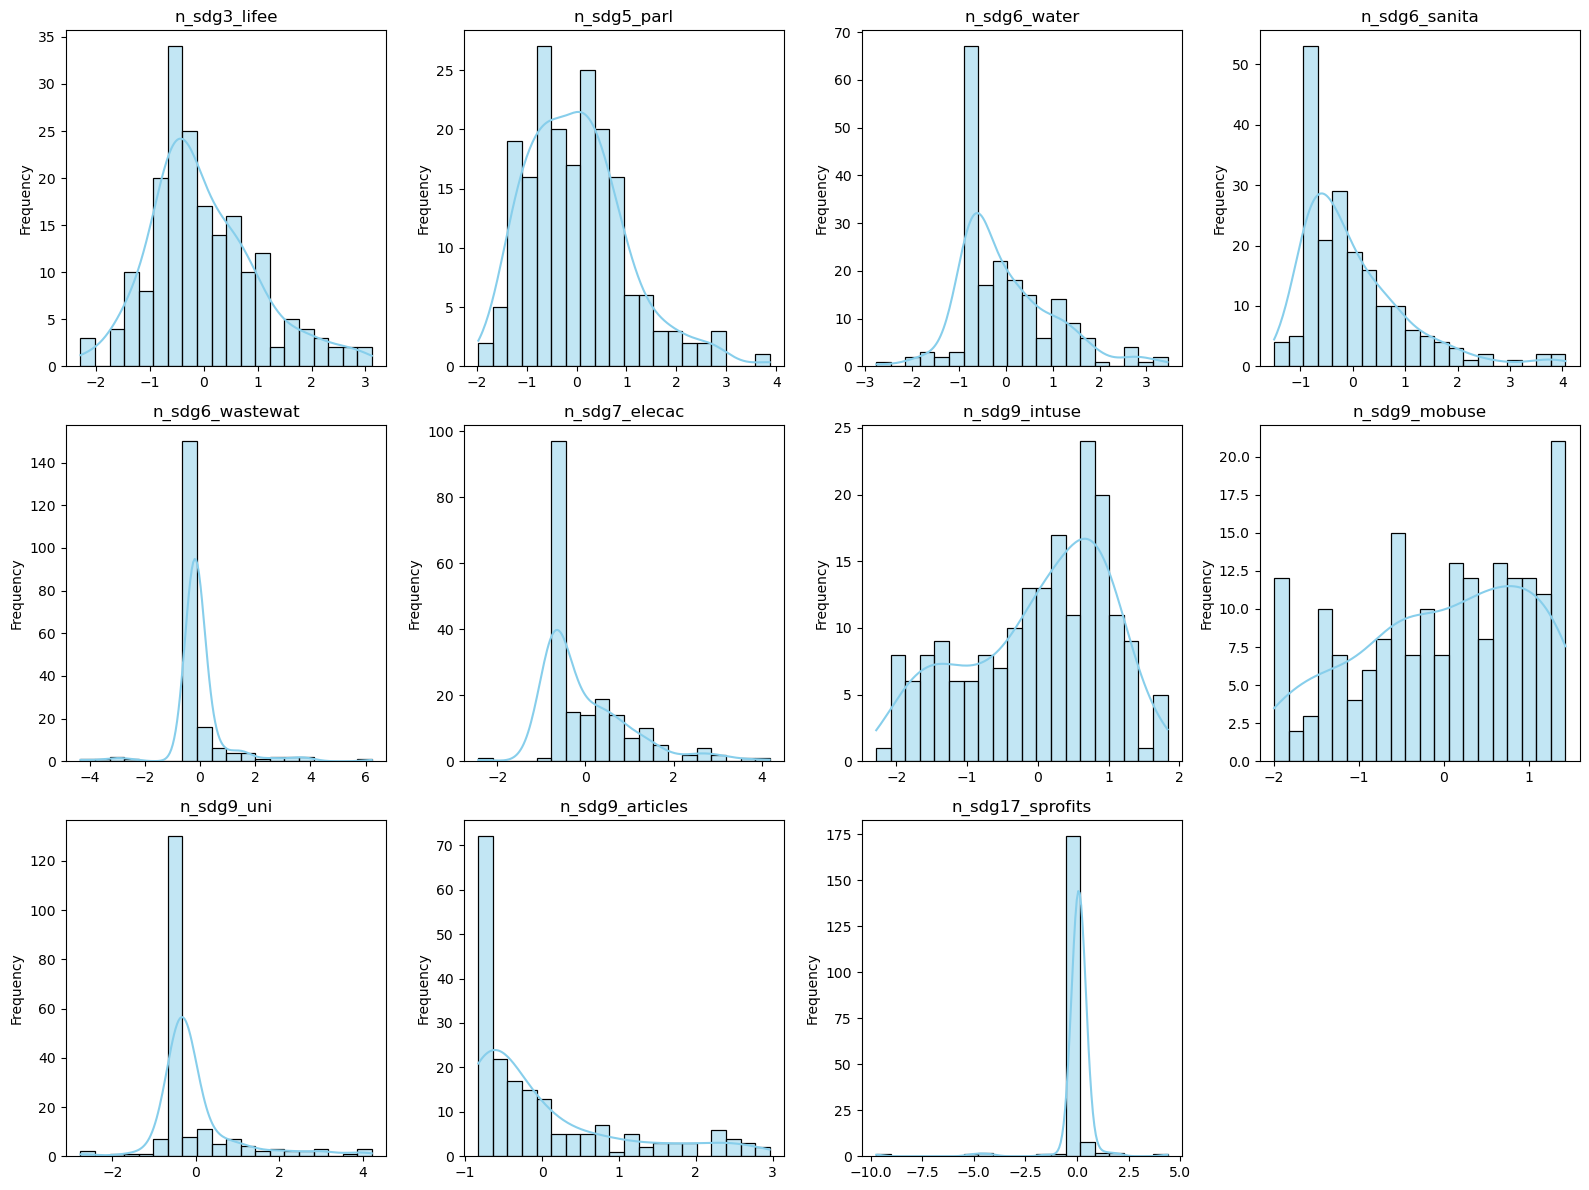

In [77]:
# scale X
X = df_growth_clean.drop(columns=["Country", "sdgi_s"]).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Plot distributions
n_cols = 4  # number of plots per row
n_rows = (len(X_scaled_df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, col in enumerate(X_scaled_df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(X_scaled_df[col], kde=True, bins=20, color="skyblue")
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



/var/folders/w0/_4jn_wpx15zbcj847_kd1rhm0000gn/T/ipykernel_1615/1059848051.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # qualitative colormap with 20 distinct colors


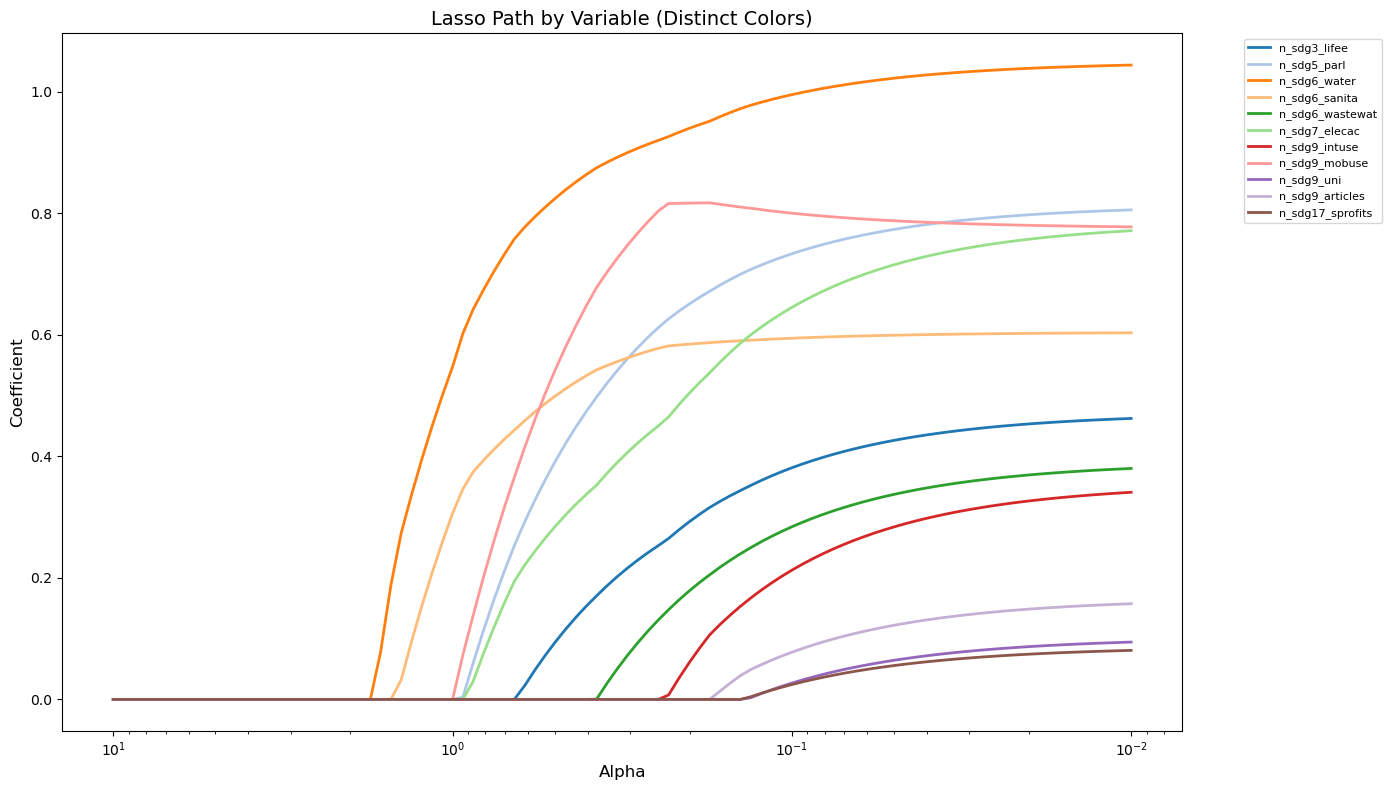

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import lasso_path
from matplotlib.cm import get_cmap

y = df_growth_clean.sdgi_s.copy()
X = df_growth_clean.drop(columns=["Country", "sdgi_s"]).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute Lasso path
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=np.logspace(-2, 1, 100))

# Choose a colormap with enough distinct colors
n_features = X.shape[1]
cmap = get_cmap('tab20')  # qualitative colormap with 20 distinct colors
colors = [cmap(i % 20) for i in range(n_features)]  # cycle if >20

# Plot Lasso path with unique colors and labels
plt.figure(figsize=(14, 8))
for i, col in enumerate(X.columns):
    plt.plot(alphas, coefs[i], label=col, color=colors[i], linewidth=2)

plt.xlabel("Alpha", fontsize=12)
plt.ylabel("Coefficient", fontsize=12)
plt.title("Lasso Path by Variable (Distinct Colors)", fontsize=14)
plt.xscale("log")
plt.gca().invert_xaxis()  # High alphas on the left

# Make the legend scrollable if too many features
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


BCCH penalty λ = 0.2856


/var/folders/w0/_4jn_wpx15zbcj847_kd1rhm0000gn/T/ipykernel_1615/77162602.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


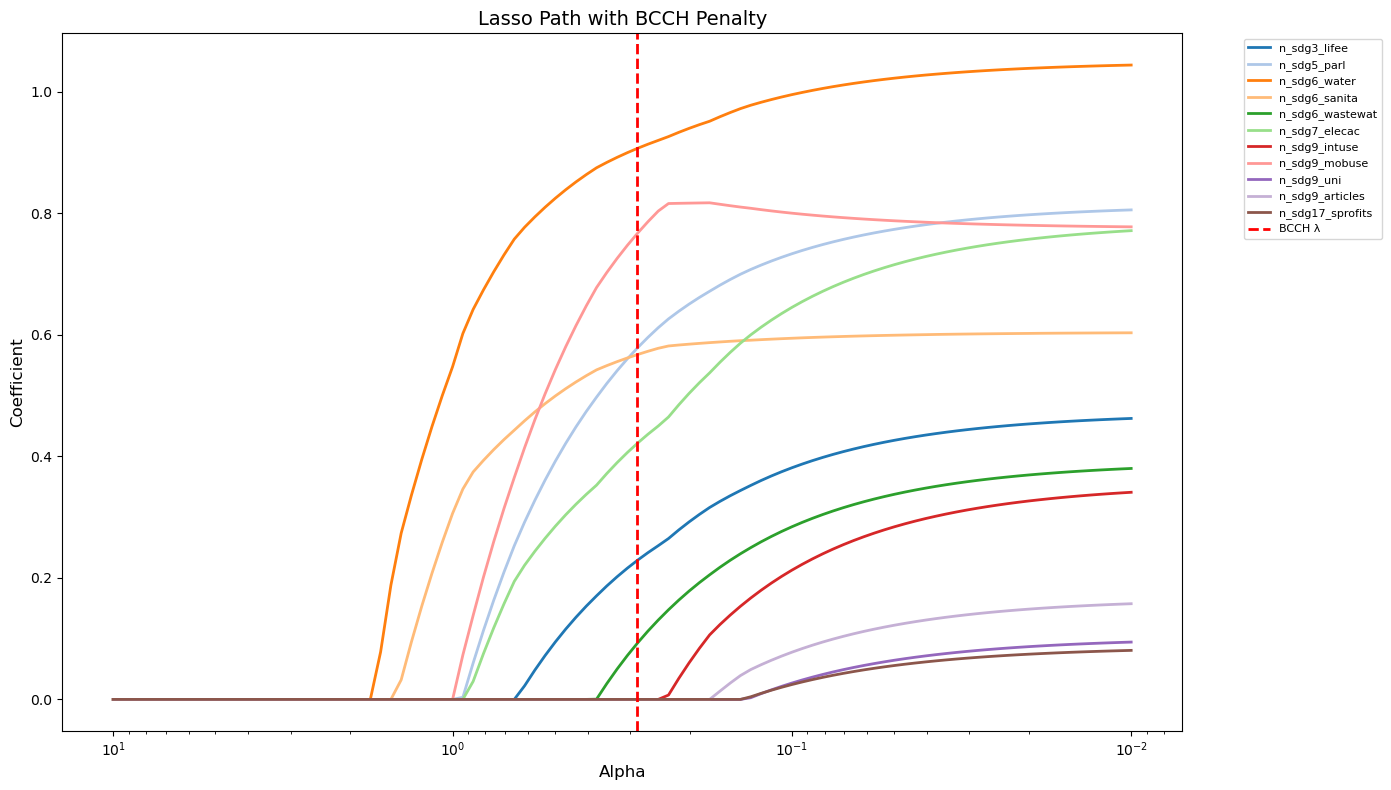

In [76]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap

# Data
y = df_growth_clean.sdgi_s.copy()
X = df_growth_clean.drop(columns=["Country", "sdgi_s"]).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n, p = X_scaled.shape

# Estimate residual std (using OLS on small subset, simple approximation)
beta_ols = np.linalg.lstsq(X_scaled, y, rcond=None)[0]
resid = y - X_scaled @ beta_ols
sigma_hat = np.std(resid, ddof=p)

# BCCH penalty
c = 1.2  # constant > 1
lambda_bcch = c * sigma_hat * np.sqrt(np.log(p)/n)
print(f"BCCH penalty λ = {lambda_bcch:.4f}")

# Lasso path
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=np.logspace(-2, 1, 100))

# Colors for variables
n_features = X.shape[1]
cmap = get_cmap('tab20')
colors = [cmap(i % 20) for i in range(n_features)]

# Plot
plt.figure(figsize=(14, 8))
for i, col in enumerate(X.columns):
    plt.plot(alphas, coefs[i], label=col, color=colors[i], linewidth=2)

# Add BCCH lambda as vertical line
plt.axvline(lambda_bcch, color='red', linestyle='--', linewidth=2, label='BCCH λ')

plt.xlabel("Alpha", fontsize=12)
plt.ylabel("Coefficient", fontsize=12)
plt.title("Lasso Path with BCCH Penalty", fontsize=14)
plt.xscale("log")
plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()
